In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint



In [253]:
target = pd.read_csv('../data/processed/properties.csv')
features = pd.read_csv('../data/processed/features.csv')

df = pd.merge(target, features, on='period')

df

,period,num_nodes,num_edges,density,clustering,assortativity,shortest_path,TPU,GPR,GPRT,...,CPTOTSAXN,DXGSRMRCHSACD,DMGSRMRCHSACD,IPTOTSAKD,IMPCOV,NEER,REER,RETSALESSA,TOTRESV,UNEMPSA_
0,2000M01,109,300,0.050968,0.521949,-0.620508,2.078491,32.117348,64.457809,65.573601,...,76.089042,4.847711e+05,7.843495e+05,9.967223e+11,2.476091,883.756875,104.048961,61.870157,1.942120e+06,8.614909
1,2000M02,122,333,0.045116,0.496115,-0.616266,NaN,28.175856,63.541721,57.651360,...,76.318397,4.967010e+05,9.434444e+05,1.010232e+12,2.063868,896.988312,104.329262,62.339465,1.947145e+06,8.620393
2,2000M03,118,342,0.049544,0.581137,-0.617675,2.092424,36.838506,50.101986,55.030735,...,76.498010,4.979957e+05,8.461331e+05,1.014447e+12,2.330691,903.555596,104.515925,62.045241,1.972075e+06,8.500496
3,2000M04,118,339,0.049109,0.611388,-0.631199,2.095755,35.281040,48.682739,53.304905,...,76.454511,4.824444e+05,8.600839e+05,1.018283e+12,2.299383,910.134906,104.679618,60.628472,1.977663e+06,8.448069
4,2000M05,115,344,0.052479,0.594336,-0.595801,2.056445,49.327563,79.482880,77.269699,...,76.617165,5.063547e+05,8.945508e+05,1.029954e+12,2.225832,931.339312,105.262834,60.970381,1.991119e+06,8.425447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,2023M05,199,2117,0.107456,0.727103,-0.520612,2.087153,59.618718,109.578575,125.211044,...,160.950844,1.818977e+06,3.163229e+06,1.850681e+12,4.210730,103.076979,104.164061,101.669815,1.331950e+07,5.756757
281,2023M06,199,2067,0.104919,0.742275,-0.528998,2.096493,52.469568,114.317734,135.593628,...,161.872466,1.783451e+06,3.141255e+06,1.857854e+12,4.255415,103.082491,104.060070,101.581524,1.336734e+07,5.671820
282,2023M07,193,1984,0.107081,0.696570,-0.531930,2.093372,63.534176,107.562927,124.753227,...,163.743367,1.776108e+06,3.043393e+06,1.854203e+12,4.417223,102.642779,103.388379,101.394009,1.344335e+07,5.748690
283,2023M08,190,1943,0.108215,0.753161,-0.526558,2.094514,60.195636,105.108551,123.208466,...,165.781302,1.803101e+06,3.142152e+06,1.867222e+12,4.241427,103.092791,103.754428,101.496583,1.332721e+07,5.781676


In [254]:
# Assuming df is your DataFrame
numerical_columns = df.columns.difference(['period'])  # Exclude 'Period'

# Create a StandardScaler
scaler = StandardScaler()  

# Standardize the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Use the interpolate method to fill missing values with interpolation
df = df.interpolate()

# Sort the DataFrame by the 'period' column
df = df.sort_values(by='period')

df

,period,num_nodes,num_edges,density,clustering,assortativity,shortest_path,TPU,GPR,GPRT,...,CPTOTSAXN,DXGSRMRCHSACD,DMGSRMRCHSACD,IPTOTSAKD,IMPCOV,NEER,REER,RETSALESSA,TOTRESV,UNEMPSA_
0,2000M01,-1.948394,-1.448399,-1.414807,-2.186714,-1.259805,-1.004870,-0.368810,-0.781599,-0.868828,...,-1.455154,-1.710588,-1.819401,-1.581324,-1.522194,2.143476,1.117513,-2.063499,-1.676405,1.318717
1,2000M02,-1.527840,-1.407005,-1.627368,-2.563903,-1.201577,-0.804972,-0.460799,-0.799224,-1.043894,...,-1.444573,-1.680488,-1.586099,-1.529528,-1.900767,2.187024,1.249075,-2.031613,-1.675187,1.325436
2,2000M03,-1.657241,-1.395715,-1.466552,-1.322546,-1.220917,-0.605075,-0.258625,-1.057799,-1.101804,...,-1.436288,-1.677221,-1.728800,-1.513366,-1.655725,2.208639,1.336687,-2.051603,-1.669144,1.178535
3,2000M04,-1.657241,-1.399478,-1.482336,-0.880870,-1.406572,-0.509464,-0.294974,-1.085105,-1.139942,...,-1.438294,-1.716458,-1.708341,-1.498659,-1.684477,2.230293,1.413517,-2.147863,-1.667789,1.114300
4,2000M05,-1.754292,-1.393207,-1.359942,-1.129837,-0.920644,-1.637492,0.032853,-0.492522,-0.610367,...,-1.430791,-1.656131,-1.657798,-1.453912,-1.752025,2.300082,1.687255,-2.124633,-1.664528,1.086583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,2023M05,0.963130,0.830795,0.636801,0.808630,0.111523,-0.756320,0.273035,0.086508,0.449043,...,2.459562,1.655700,1.669072,1.692834,0.070846,-0.425940,1.171536,0.640619,1.081453,-2.183173
281,2023M06,0.963130,0.768076,0.544625,1.030148,-0.003597,-0.488312,0.106183,0.177688,0.678478,...,2.502077,1.566066,1.636849,1.720333,0.111883,-0.425922,1.122727,0.634620,1.093050,-2.287241
282,2023M07,0.769028,0.663963,0.623170,0.362828,-0.043841,-0.577854,0.364416,0.047728,0.438926,...,2.588382,1.547540,1.493341,1.706337,0.260482,-0.427369,0.807463,0.621880,1.111473,-2.193057
283,2023M08,0.671977,0.612534,0.664349,1.189087,0.029894,-0.545087,0.286499,0.000507,0.404790,...,2.682393,1.615646,1.638165,1.756251,0.099037,-0.425888,0.979271,0.628849,1.083322,-2.152642


### Uncertainty for each property
1.准备三个数据集，y分别是对应到滞后1、3、6期的。如果只使用一个树模型【表格数据用树模型效果可以】，模型一共应该有3*n个，n是网络结构指标
2.对每个数据集，分train test数据集【这个注意按时间排，时间靠后的放在测试集】，再对train做cross-validation+random search做参数调优得到最佳参数
3.用最佳参数的模型测试集上预测得到测试集的mse【这个只是报告用】。
4.用最佳参数的模型在整个数据集上预测，用这个预测结果和真实结果计算每个时间点的mse
5.重复2-4，得到所有mse

In [266]:
import pandas as pd

# Assuming df is your original DataFrame
# Make sure to replace 'your_target_columns' with the actual names of your target columns
target_columns = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Copy the original DataFrame to avoid modifying the original data
lag1_df = df.copy()
lag3_df = df.copy()
lag6_df = df.copy()

# Shift target columns by 1, 3, and 6 periods in respective lag DataFrames
for column in target_columns:
    lag1_df[f'{column}'] = lag1_df[column].shift(1)
    lag3_df[f'{column}'] = lag3_df[column].shift(3)
    lag6_df[f'{column}'] = lag6_df[column].shift(6)

# Drop rows with NaN values in lag DataFrames
lag1_df = lag1_df.dropna()
lag3_df = lag3_df.dropna()
lag6_df = lag6_df.dropna()


In [271]:
lag6_df

,period,num_nodes,num_edges,density,clustering,assortativity,shortest_path,TPU,GPR,GPRT,...,CPTOTSAXN,DXGSRMRCHSACD,DMGSRMRCHSACD,IPTOTSAKD,IMPCOV,NEER,REER,RETSALESSA,TOTRESV,UNEMPSA_
6,2000M07,-1.948394,-1.448399,-1.414807,-2.186714,-1.259805,-1.004870,-0.372846,-1.023129,-1.051283,...,-1.406046,-1.658084,-1.641175,-1.444446,-1.761318,2.237428,1.440667,-2.184318,-1.660633,1.106751
7,2000M08,-1.527840,-1.407005,-1.627368,-2.563903,-1.201577,-0.804972,-0.436603,-1.127249,-1.230823,...,-1.400080,-1.619518,-1.637311,-1.416254,-1.768660,2.292894,1.660779,-2.179509,-1.660979,1.100157
8,2000M09,-1.657241,-1.395715,-1.466552,-1.322546,-1.220917,-0.605075,-0.338134,-1.008007,-0.893768,...,-1.386078,-1.651850,-1.568310,-1.428798,-1.853664,2.346472,1.931123,-2.164780,-1.657238,0.991100
9,2000M10,-1.657241,-1.399478,-1.482336,-0.880870,-1.406572,-0.509464,-0.523691,-0.550748,-0.497271,...,-1.380119,-1.654179,-1.670221,-1.417600,-1.701917,2.375638,2.178595,-2.278086,-1.657379,0.909625
10,2000M11,-1.754292,-1.393207,-1.359942,-1.129837,-0.920644,-1.637492,-0.490463,-1.154794,-1.337658,...,-1.369340,-1.644759,-1.612336,-1.393984,-1.767597,2.377276,2.216282,-2.261600,-1.651605,0.867683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,2023M05,1.027830,1.050310,0.875541,0.966208,0.270491,-1.124330,0.273035,0.086508,0.449043,...,2.459562,1.655700,1.669072,1.692834,0.070846,-0.425940,1.171536,0.640619,1.081453,-2.183173
281,2023M06,0.995480,0.973793,0.805834,0.816779,0.368889,-1.027910,0.106183,0.177688,0.678478,...,2.502077,1.566066,1.636849,1.720333,0.111883,-0.425922,1.122727,0.634620,1.093050,-2.287241
282,2023M07,0.542576,0.668981,0.930672,1.231587,0.260621,-2.036354,0.364416,0.047728,0.438926,...,2.588382,1.547540,1.493341,1.706337,0.260482,-0.427369,0.807463,0.621880,1.111473,-2.193057
283,2023M08,0.736678,0.731699,0.770855,0.962372,0.233535,-1.013035,0.286499,0.000507,0.404790,...,2.682393,1.615646,1.638165,1.756251,0.099037,-0.425888,0.979271,0.628849,1.083322,-2.152642


In [273]:

def perform_random_search_cv(X_train, y_train):
    param_dist = {
        'n_estimators': randint(10, 100),
        'max_depth': [None] + list(np.arange(3, 20)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf_model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)

    random_search = RandomizedSearchCV(
        rf_model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42
    )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    return random_search.best_estimator_

def calculate_mse_per_period(df, target_column):
    features = df.columns[7:]  # Exclude 'period' and targets
    target = target_column

    # Split the dataset into train and test sets based on time
    train_size = int(len(df) * 0.8)
    train_set, test_set = df[:train_size], df[train_size:]

    # Perform cross-validation and random search for hyperparameter tuning on the training set
    best_model = perform_random_search_cv(train_set[features], train_set[target])

    # Evaluate the best model on the test set
    test_predictions = best_model.predict(test_set[features])
    overall_test_mse = mean_squared_error(test_set[target], test_predictions)
    print(f'Overall Test Set Mean Squared Error for {target_column}: {overall_test_mse}')

    # Use the best model to predict on the entire dataset
    full_dataset_predictions = best_model.predict(df[features])

    # Add the predicted values to the DataFrame
    df[f'predicted_{target_column}'] = full_dataset_predictions

    # Calculate MSE for each period
    mse_per_period = df.groupby('period').apply(lambda group: mean_squared_error(group[target], group[f'predicted_{target_column}'])).reset_index()
    mse_per_period.columns = ['period', f'mse_{df}']
    return mse_per_period


In [274]:

# List of columns to iterate through
columns_to_calculate_mse = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Dictionary to store the calculated MSE DataFrames for each column
mse_per_column_dict = {}

# Assuming lag1_df, lag2_df, lag3_df are your lag DataFrames
for column in columns_to_calculate_mse:
    lag1_mse = calculate_mse_per_period(lag1_df, target_column=column)
    lag3_mse = calculate_mse_per_period(lag3_df, target_column=column)
    lag6_mse = calculate_mse_per_period(lag6_df, target_column=column)

    # Merge the MSE DataFrames on the 'period' column
    merged_mse_df = lag1_mse.merge(lag3_mse, on='period').merge(lag6_mse, on='period')

    # Rename the columns to include the column name and lag
    merged_mse_df.columns = ['period', f'mse_lag1_{column}', f'mse_lag3_{column}', f'mse_lag6_{column}']

    # Store the MSE DataFrame for the current column in the dictionary
    mse_per_column_dict[column] = merged_mse_df

# Create separate DataFrames for each lag
lag1_mse = pd.concat([mse_df[f'mse_lag1_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag3_mse = pd.concat([mse_df[f'mse_lag3_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag6_mse = pd.concat([mse_df[f'mse_lag6_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)

# Include the 'period' column in the resulting DataFrames
lag1_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])
lag3_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])
lag6_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])



# Display the resulting DataFrames
# print("MSE DataFrame for lag1:")
# print(lag1_mse)
# 
# print("\nMSE DataFrame for lag2:")
# print(lag2_mse)
# 
# print("\nMSE DataFrame for lag3:")
# print(lag3_mse)


Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 98}
Overall Test Set Mean Squared Error for num_nodes: 0.0005178811733284758
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 98}
Overall Test Set Mean Squared Error for num_nodes: 0.00011569673584540448
Best Parameters: {'bootstrap': False, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 53}
Overall Test Set Mean Squared Error for num_nodes: 0.04197368398807679
Best Parameters: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 18}
Overall Test Set Mean Squared Error for num_edges: 0.018224561664477796
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 98}
Overall Test Set Mean Squared Error for num_edges: 0.01730278025377391
Best Parameters: {'boots

In [278]:
lag1_mse

,period,mse_lag1_num_nodes,mse_lag1_num_edges,mse_lag1_density,mse_lag1_clustering,mse_lag1_assortativity,mse_lag1_shortest_path
0,2000M07,2.616348e-04,0.000022,0.000598,0.008888,0.003029,0.007918
1,2000M08,6.540870e-03,0.000278,0.000004,0.450529,0.001510,0.408140
2,2000M09,2.415887e-30,0.000119,0.031112,0.198068,0.014624,0.130598
3,2000M10,1.232595e-30,0.000030,0.019655,0.001987,0.019867,0.007573
4,2000M11,1.232595e-30,0.000049,0.021708,0.123070,0.001752,0.153056
...,...,...,...,...,...,...,...
274,2023M05,9.984021e-31,0.088131,0.059308,0.000008,1.228072,0.780330
275,2023M06,1.972152e-31,0.021051,0.045407,0.097633,1.406686,2.059509
276,2023M07,1.972152e-31,0.063241,0.093187,0.288653,1.693012,1.488683
277,2023M08,1.109336e-31,0.126445,0.051402,0.182652,1.799359,0.044577


In [279]:
lag3_mse

,period,mse_lag3_num_nodes,mse_lag3_num_edges,mse_lag3_density,mse_lag3_clustering,mse_lag3_assortativity,mse_lag3_shortest_path
0,2000M07,1.774937e-30,0.000025,5.693145e-04,0.326515,0.037593,0.045805
1,2000M08,2.616348e-04,0.000002,1.857980e-04,0.051001,0.024620,1.016432
2,2000M09,2.616348e-04,0.000190,6.900802e-07,0.000103,0.070979,0.085167
3,2000M10,6.540870e-03,0.000004,5.360431e-03,0.166286,0.004809,1.007430
4,2000M11,2.415887e-30,0.000057,7.940509e-03,0.097316,0.022172,0.327911
...,...,...,...,...,...,...,...
274,2023M05,4.930381e-32,0.056608,3.281574e-02,0.144326,0.629198,2.081916
275,2023M06,6.039716e-31,0.002312,8.310221e-03,0.104325,0.650720,2.553422
276,2023M07,9.984021e-31,0.068949,7.582162e-02,0.031011,0.678271,2.687651
277,2023M08,1.972152e-31,0.020888,4.342521e-02,0.070119,0.780323,2.916724


In [280]:
lag6_mse

,period,mse_lag6_num_nodes,mse_lag6_num_edges,mse_lag6_density,mse_lag6_clustering,mse_lag6_assortativity,mse_lag6_shortest_path
0,2000M07,0.111368,0.002541,1.973985e-04,0.114721,0.002223,0.187640
1,2000M08,0.007540,0.000032,3.114967e-03,0.112572,0.000057,0.062318
2,2000M09,0.001812,0.000383,9.994803e-04,0.087732,0.000890,0.112512
3,2000M10,0.001812,0.000017,1.589611e-07,0.217360,0.008598,0.088089
4,2000M11,0.019493,0.000040,1.086842e-02,0.035903,0.010973,1.259553
...,...,...,...,...,...,...,...
274,2023M05,0.079473,0.011018,5.316927e-03,0.007637,0.559431,4.525905
275,2023M06,0.062280,0.001221,3.287058e-02,0.000055,0.451293,4.819118
276,2023M07,0.041349,0.072917,1.196105e-03,0.184359,0.617004,10.621373
277,2023M08,0.000085,0.043691,2.387902e-02,0.061694,0.541741,4.243267


In [281]:

# Function to calculate 'uncertainty' by weight for each row in lag_mse
def calculate_uncertainty_metrics(mse_df):
    # Calculate the variance of each column in mse_df
    variances = mse_df.iloc[:, 1:7].var()

    # Calculate 'weighted_uncertainty' (weighted average of the sum of the other columns)
    mse_df['uncertainty'] = (mse_df.iloc[:, 1:7] * variances).sum(axis=1) / variances.sum()
    
    uncertainties = mse_df[['period','uncertainty']]
    
    return uncertainties

In [282]:

# Calculate 'avg_uncertainty' and 'weighted_uncertainty' for each row in mse_df
uncertainties_1 = calculate_uncertainty_metrics(lag1_mse)
uncertainties_3 = calculate_uncertainty_metrics(lag3_mse)
uncertainties_6 = calculate_uncertainty_metrics(lag6_mse)

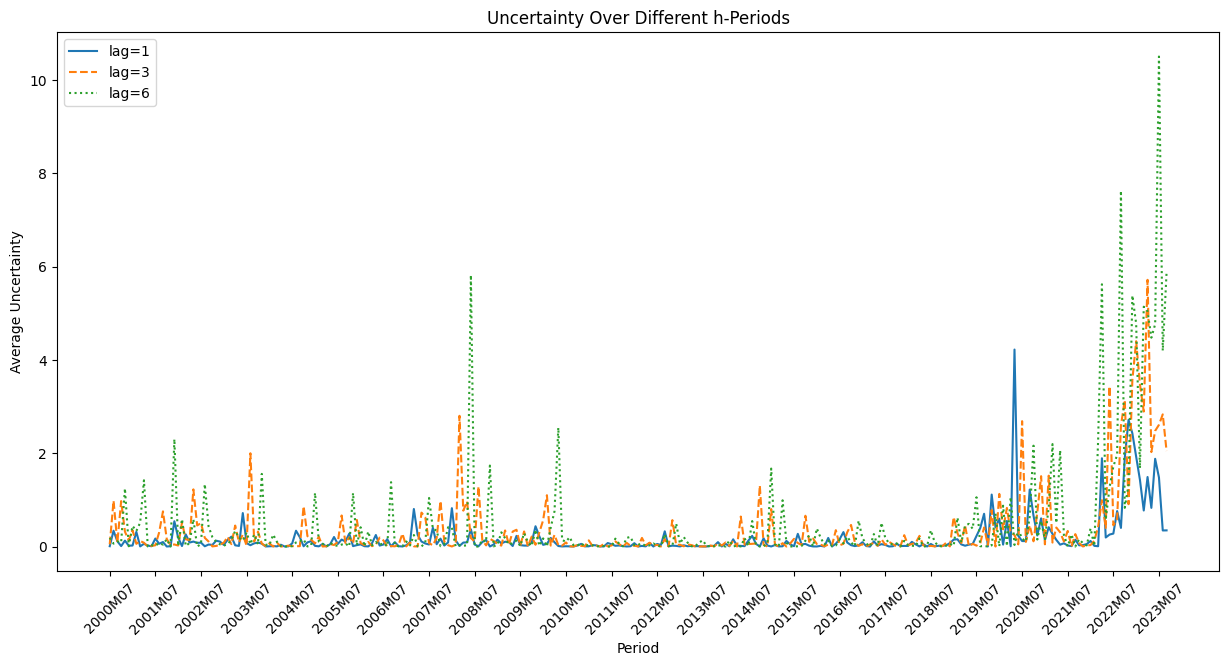

In [283]:
# Plot 'avg_uncertainty'
plt.figure(figsize=(15, 7))
plt.plot(uncertainties_1['period'], uncertainties_1['uncertainty'], label='lag=1', linestyle='-')
plt.plot(uncertainties_3['period'], uncertainties_3['uncertainty'], label='lag=3', linestyle='--')
plt.plot(uncertainties_6['period'], uncertainties_6['uncertainty'], label='lag=6', linestyle=':')


plt.title('Uncertainty Over Different h-Periods')
plt.xlabel('Period')
plt.ylabel('Average Uncertainty')
plt.legend()

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(uncertainties_1['period'][::12], rotation=45)
plt.show()



In [284]:
# save to csv
uncertainties_1.to_csv('../data/processed/uncertainty_index.csv', index=False, encoding='utf')